This example is an MB-MVPA code that uses part of the data (Tom et al., 2007).<br>
Tom's full dataset used 16 subjects, but in this example, only 2 subjects are used to save resource.

### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from mbmvpa.preprocessing.bids import bids_preprocess
from mbmvpa.preprocessing.events import events_preprocess
from mbmvpa.data.loader import prepare_dataset
from mbmvpa.utils.example_utils import load_example_data

Data download from AWS S3, ~ <b>1GB</b>.<br>
If you run this example more than once, the data will already be downloaded.<br>
If so, do not download it again.

In [3]:
root = load_example_data("tom")

data load success! (tom)


### Preprocessing bids data (fMRI)

The MB-MVPA liabrary need to BIDS format including preprocessed nii images(<i>nii or nii.gz</i>) and behavior data file*(.tsv)*.<br>
The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

``` python
def bids_preprocess(
    root, # (str or Path): the root directory of BIDS layout.
    layout, # (bids.BIDSLayout): BIDSLayout by bids package. if not provided, it will be obtained from root path.
    save_path, # (str or Path): a path for the directory to save output (X, voxel_mask).
    mask_path, # (str or Path): a path for the directory containing mask files (nii or nii.gz). encourage get files from Neurosynth.
    threshold, # (float): threshold for binarizing mask images
    zoom, # (tuple[float, float, float]): zoom window, indicating a scaling factor for each dimension in x,y,z.
    smoothing_fwhm, # (int or None): the amount of spatial smoothing. if None, image will not be smoothed.
    interpolation_func, # (numpy.function): a method to calculate a representative value in the zooming window.
    standardize, # (bool): if true, conduct standard normalization within each image of a single run.
    motion_confounds, # (list[str, str, ..., str]): list of motion confound names in confounds tsv file. 
    ncore, # int): the number of core for the tparallel computing.
    nthread, # (int): the number of thread for the parallel computing.
)
```

In [4]:
X, voxel_mask, layout, data_root = bids_preprocess(root, smoothing_fwhm=None, zoom=(2, 2, 2), ncore=2, nthread=4)

bids preprocessing done!                          : 100%|██████████| 6/6 [00:19<00:00,  3.32s/it] 


<b><i>X</i> (<i>numpy.ndarray</i>)</b>: subject-wise & run-wise BOLD time series data.<br>
<b><i>voxel_mask</i> (<i>nibabel.nifti1.Nifti1Image</i>)</b>: a nifti image for voxel-wise binary mask (ROI mask)<br>
<b><i>layout</i> (<i>bids.layout</i>)</b>: The loaded layout.<br>
<b><i>data_root</i> (<i>str</i>)</b>: Equal to layout.derivatives["fMRI"].root.

### Preprocessing bids data (events)

Our mbmvpa is directly inputted into the data and modulation functions to be used to increase user's freedom and increase stability.<br>
The following three functions must be completed, each of which means:<br>
1. If you use <b><i>hbayesDM</i></b>, you should change the columns name to suit it. -> <i>preprocess_columns</i><br>
2. If you only want to use behavioral data under certain conditions, you must define a condition function. -> <i>condition</i><br>
3. Finally, since we are model-based fMRI, we have to calculate the modulation.<br>
   The important point is that the behavioral data that we already have are in the <b><i>row</i></b>, and parameters estimated by model are in the <b><i>param_dict</i></b>.<br>
   -> <i>modulation</i>

If you have parameters already calculated and can provide them in *.tsv*, we also allow that.<br>
<b><i>individual_params_custom</i></b> has the role.<br>
In that case, the dm_model, or deicison making model, is not required but modulation functions is still required.

``` python
def example_tom_preprocess_columns(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_tom_condition(row):
    # include all trial data
    return True
```

In this example, we used individual parameters created by the above two functions.<br>
But, still required modulation function like bellow.<br>
If you want to skip even this, you need to pass a dataframe with <b><i>modulation, subjID, run, onset, duration</i></b>

In [5]:
def example_tom_modulation(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row

If you want to know more about the equation above, please refer to this.<br>
https://ccs-lab.github.io/hBayesDM/reference/ra_prospect.html

``` python
def events_preprocess(
    root, # (str or Path): The root directory of BIDS layout
    layout, # (bids.BIDSLayout): BIDSLayout by bids package. if not provided, it will be obtained from root path.
    save_path, # (str or Path): A path for the directory to save outputs (y, time_mask) and intermediate data (individual_params_custom, df_events).
    preprocess, # preprocess (function(pandas.Series, dict)-> pandas.Series)): A user-defined function for modifying each row of behavioral data.
    condition, # (function(pandas.Series)-> boolean)): A user-defined function for filtering each row of behavioral data.
    modulation, # (function(pandas.Series, dict)-> Series): A user-defined function for calculating latent process (modulation).
    condition_for_modeling, # (None or function(pandas.Series)-> boolean)): A user-defined function for filtering each row of behavioral data.
    dm_model, # (str or pathlib.Path or hbayesdm.models): Computational model by hBayesDM package. should be provided as the name of the model
    individual_params_custom, # (None or str or Path or pandas.DataFrame): pandas dataframe with params_name columns and corresponding values for each subject.
    hrf_model, # (str): The name for hemodynamic response function, which will be convoluted with event data to make BOLD-like signal.
    normalizer, # (str): A name for normalization method, which will normalize BOLDified signal.
    df_events_custom, # (str or Path or pandas.DataFrame)
    use_duration, # (boolean): If True use "duration" column to make time mask, if not regard gap between consecuting trials" onset values as duration
    scale, # (tuple(float, float)): Lower bound and upper bound for minmax scaling.
    **kwargs # keyward arguments for hbayesdm.models.
)
```

In [6]:
dm_model, df_events, signals, time_masks, _ = \
    events_preprocess(root,
                      modulation=example_tom_modulation,
                      individual_params_custom="../example_data/tom_example/derivatives/fmriprep/mvpa/individual_params.tsv")

calculating modulation..                          :  71%|███████▏  | 5/7 [00:02<00:01,  1.67it/s]  INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
events preproecssing done!                        : 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


<b><i>dm_model (str or hbayesdm.models)</i></b>: hBayesDM model or it's name.<br>
<b><i>df_events (pandas.DataFrame)</i></b>: Integrated events DataFrame (preprocessed if not provided) with <b><i>onset, duration, modulation.</i></b><br>
<b><i>signals (numpy.ndarray)</i></b>: BOLD-like signals with shape: <b><i>subject # x (session # x run #) x time length of scan x voxel #</i></b>.<br>
<b><i>time_mask (numpy.ndarray)</i></b>: A binary mask indicating valid time point with shape: <b><i>subject # x (session # x run #) x time length of scan.</i></b>

### Load data and shape check

Through the above process, <b><i>subject, session and run-wise fMRI images and modulation values are obtained</i></b><br>
<b><i>Both X(fMRI), y(modulation)'s shape[0] must equal.</i></b><br>
The <b><i>prepare_dataset</i></b> function operate shape check and time and voxel masking.

``` python
def prepare_dataset(
    root, # (str or pathlib.Path): Path where created data (X, y, time_mask, voxel_mask) is stored.
    time_masking=True, # (bool): Whether to do time masking or not.
    voxel_masking=True # (bool): Whether to do voxel masking or not.
)
```

In [7]:
X, y, voxel_mask = prepare_dataset(data_root)

<b><i>X (numpy.ndarray)</i></b>: X, which is adjusted dimension and masked time points for training with shape: data # x voxel #.<br>
<b><i>y (numpy.ndarray)</i></b>: y, which is adjusted dimension and masked time points for training with shape: data #.<br>
<b><i>voxel_mask (nibabel.nifti1.Nifti1Image)</i></b>: Voxel mask file for get result brain map.

### Fitting MVPA models & Results

In [8]:
from mbmvpa.utils.coef2map import get_map
from time import perf_counter

In [9]:
from mbmvpa.models.regressor import penalized_linear_regression

s = perf_counter()
coefs = penalized_linear_regression(X, y,
                                    layout,
                                    lambda_param=2.0,
                                    N=10,
                                    verbose=1)
result = get_map(coefs, voxel_mask, task_name="tom2007_penalized_linear", map_type="z", save_path=".", sigma=1)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

INFO:root:[1/10] - val_mse: 0.1751
INFO:root:[2/10] - val_mse: 0.1637
INFO:root:[3/10] - val_mse: 0.1631
INFO:root:[4/10] - val_mse: 0.1691
INFO:root:[5/10] - val_mse: 0.1629
INFO:root:[6/10] - val_mse: 0.1647
INFO:root:[7/10] - val_mse: 0.1510
INFO:root:[8/10] - val_mse: 0.1635
INFO:root:[9/10] - val_mse: 0.1718
INFO:root:[10/10] - val_mse: 0.1588


elapsed time: 1.10 minutes


In [10]:
from mbmvpa.models.regressor import mlp_regression

s = perf_counter()
coefs = mlp_regression(X, y,
                       layout,
                       layer_dims=[1024, 1024],
                       activation="linear",
                       dropout_rate=0.5,
                       epochs=100,
                       patience=10,
                       batch_size=64,
                       N=3,
                       verbose=1)
result = get_map(coefs, voxel_mask, task_name="tom2007_mlp", map_type="z", save_path=".", sigma=1)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

INFO:root:[1/3] - val_loss: 0.1563
INFO:root:[2/3] - val_loss: 0.1524
INFO:root:[3/3] - val_loss: 0.1458


elapsed time: 0.61 minutes


INFO:root:[1/1] - lambda_best: 1.000/ mse: 0.1002


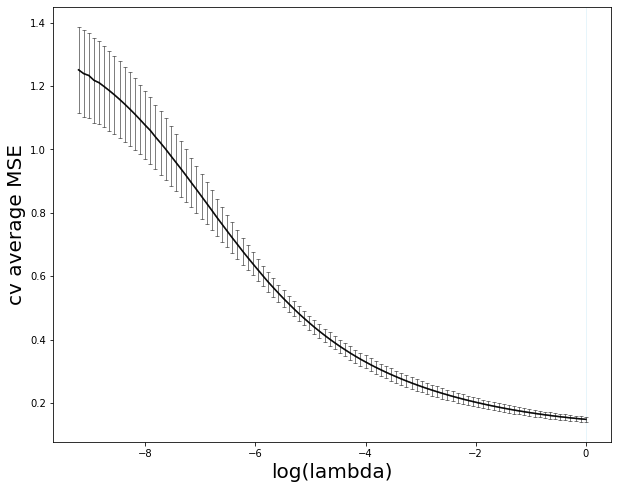

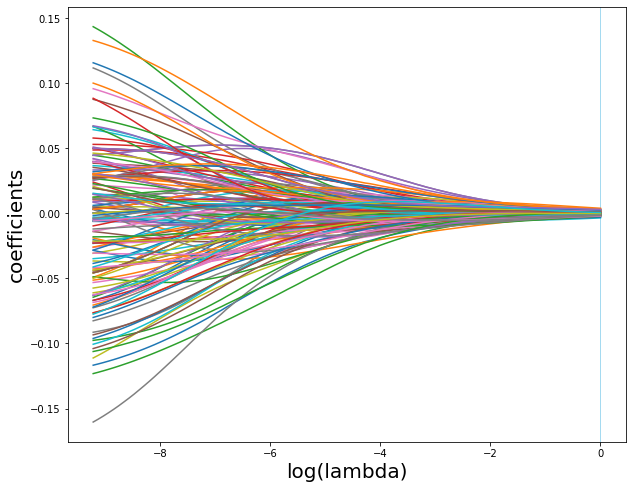

elapsed time: 0.34 minutes


In [11]:
from mbmvpa.models.regressor import elasticnet

s = perf_counter()
coefs = elasticnet(X, y,
                   layout,
                   n_jobs=16,
                   verbose=1,
                   max_lambda=1,
                   n_samples=5000)
result = get_map(coefs, voxel_mask, task_name="tom2007_elasticnet", map_type="z", save_path=".", sigma=1)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")